In [1]:
#IMPORTING ALL THE LIBRARY 
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
import pickle
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from math import ceil
from collections import defaultdict
from tqdm.notebook import tqdm  
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, concatenate, Bidirectional, Dot, Activation, RepeatVector, Multiply, Lambda

from nltk.translate.bleu_score import corpus_bleu

# **Image Captioning**

**What is Image Captioning ?**
- Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions.
- This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

**CNNs + RNNs (LSTMs)**
- To perform Image Captioning we will require two deep learning models combined into one for the training purpose
- CNNs extract the features from the image of some vector size aka the vector embeddings. The size of these embeddings depend on the type of pretrained network being used for the feature extraction
- LSTMs are used for the text generation process. The image embeddings are concatenated with the word embeddings and passed to the LSTM to generate the next word
- For a more illustrative explanation of this architecture check the Modelling section for a picture representation

<img src="https://miro.medium.com/max/1400/1*6BFOIdSHlk24Z3DFEakvnQ.png">

**IMPORTING THE DATA FROM FLICKR DATA SET **

In [2]:
image_path = '../input/flickr8k/Images'
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [3]:
INPUT_DIR = '/kaggle/input/flickr8k'
OUTPUT_DIR = '/kaggle/working'

**Here we have went forward with the DenseNet201 model to capture all the features of the Data**

In [4]:

model = DenseNet201()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Printing the model summary
print(model.summary())


82534400/82524592 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

# **Exrtracting the features of Image **


In [5]:
# Initialize an empty dictionary to store image features
image_features = {}

# Define the directory path where images are located
img_dir = os.path.join(INPUT_DIR, 'Images')

# Loop through each image in the directory
for img_name in tqdm(os.listdir(img_dir)):
    # Load the image from file
    img_path = os.path.join(img_dir, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to a numpy array
    image = img_to_array(image)
    # Reshape the data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for ResNet50
    image = preprocess_input(image)
    # Extract features using the pre-trained ResNet50 model
    image_feature = model.predict(image, verbose=0)
    # Get the image ID by removing the file extension
    image_id = img_name.split('.')[0]
    # Store the extracted feature in the dictionary with the image ID as the key
    image_features[image_id] = image_feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
# Store the image features in pickle
pickle.dump(image_features, open(os.path.join(OUTPUT_DIR, 'img_features.pkl'), 'wb'))

In [7]:
# Load features from pickle file
pickle_file_path = os.path.join(OUTPUT_DIR, 'img_features.pkl')
with open(pickle_file_path, 'rb') as file:
    loaded_features = pickle.load(file)

In [8]:
with open(os.path.join(INPUT_DIR, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

* Mapping the Images(Extracted Features) with there corresponding captions* 

In [9]:
# Create mapping of image to captions
image_to_captions_mapping = defaultdict(list)

# Process lines from captions_doc
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id, *captions = tokens
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert captions list to string
    caption = " ".join(captions)
    # Store the caption using defaultdict
    image_to_captions_mapping[image_id].append(caption)

# Print the total number of captions
total_captions = sum(len(captions) for captions in image_to_captions_mapping.values())
print("Total number of captions:", total_captions)

  0%|          | 0/40456 [00:00<?, ?it/s]

Total number of captions: 40455


In [10]:
# Function for processing the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetical characters
            caption = ''.join(char for char in caption if char.isalpha() or char.isspace())
            # Remove extra spaces
            caption = caption.replace('\s+', ' ')
            # Add unique start and end tokens to the caption
            caption = 'startseq ' + ' '.join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [11]:
# preprocess the text
clean(image_to_captions_mapping)

In [12]:
all_captions = [caption for captions in image_to_captions_mapping.values() for caption in captions]

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [14]:
with open('tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [15]:
# Calculate maximum caption length
max_caption_length = max(len(tokenizer.texts_to_sequences([caption])[0]) for caption in all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Print the results
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_length)

Vocabulary Size: 8768
Maximum Caption Length: 34


In [16]:
# Creating a List of Image IDs
image_ids = list(image_to_captions_mapping.keys())
# Splitting into Training and Test Sets
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

**PREPARATION OF DATA FOR THE MODEL **

In [17]:
def data_generator(data_keys, image_to_captions_mapping, features, tokenizer, max_caption_length, vocab_size, batch_size):
    # Lists to store batch data
    X1_batch, X2_batch, y_batch = [], [], []
    # Counter for the current batch size
    batch_count = 0

    while True:
        # Loop through each image in the current batch
        for image_id in data_keys: 
            # Get the captions associated with the current image
            captions = image_to_captions_mapping[image_id]

            # Loop through each caption for the current image
            for caption in captions:
                # Convert the caption to a sequence of token IDs
                caption_seq = tokenizer.texts_to_sequences([caption])[0]

                # Loop through the tokens in the caption sequence
                for i in range(1, len(caption_seq)):
                    # Split the sequence into input and output pairs
                    in_seq, out_seq = caption_seq[:i], caption_seq[i]

                    # Pad the input sequence to the specified maximum caption length
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]

                    # Convert the output sequence to one-hot encoded format
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append data to batch lists
                    X1_batch.append(features[image_id][0])  # Image features
                    X2_batch.append(in_seq)  # Input sequence
                    y_batch.append(out_seq)  # Output sequence

                    # Increase the batch counter
                    batch_count += 1
                    
                    
                    if batch_count == batch_size:
                        X1_batch, X2_batch, y_batch = np.array(X1_batch), np.array(X2_batch), np.array(y_batch)
                        yield [X1_batch, X2_batch], y_batch
                        X1_batch, X2_batch, y_batch = [], [], []
                        batch_count = 0


# **Caption Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove special characters and numbers present in the text
- Remove extra spaces
- Remove single characters
- Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence



## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920



# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

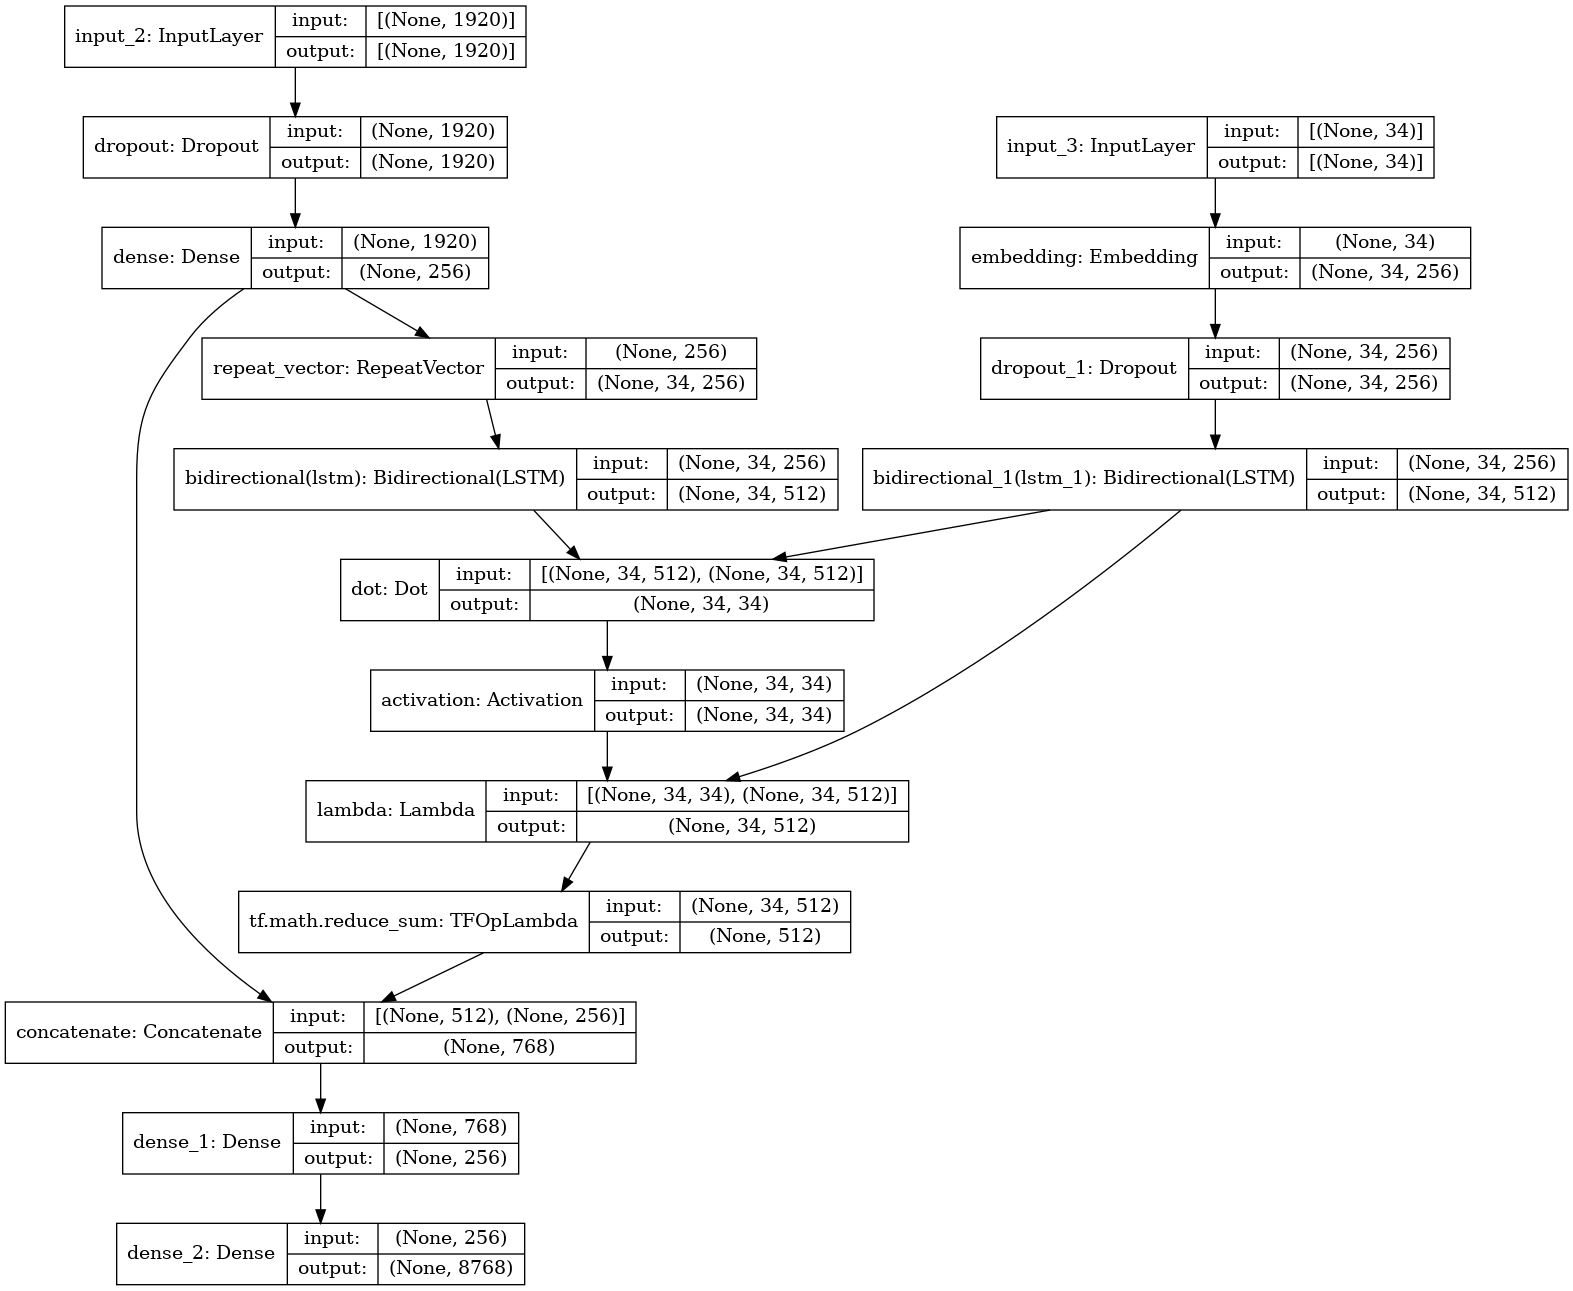

In [18]:
# Set the number of epochs, batch size
inputs1 = Input(shape=(1920,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
fe2_projected = RepeatVector(max_caption_length)(fe2)
fe2_projected = Bidirectional(LSTM(256, return_sequences=True))(fe2_projected)

# Sequence feature layers
inputs2 = Input(shape=(max_caption_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

# Apply attention mechanism using Dot product
attention = Dot(axes=[2, 2])([fe2_projected, se3])  # Calculate attention scores

# Softmax attention scores
attention_scores = Activation('softmax')(attention)

# Apply attention scores to sequence embeddings
attention_context = Lambda(lambda x: tf.einsum('ijk,ijl->ikl', x[0], x[1]))([attention_scores, se3])

# Sum the attended sequence embeddings along the time axis
context_vector = tf.reduce_sum(attention_context, axis=1)

# Decoder model
decoder_input = concatenate([context_vector, fe2], axis=-1)
decoder1 = Dense(256, activation='relu')(decoder_input)
outputs = Dense(vocab_size, activation='softmax')(decoder1)

# Create the model
model1= Model(inputs=[inputs1, inputs2], outputs=outputs)
model1.compile(loss='categorical_crossentropy', optimizer='adam')

# Visualize the model
plot_model(model1, show_shapes=True)

****

In [19]:
# Set the number of epochs, batch size
epochs = 20
batch_size = 32

# Calculate the steps_per_epoch based on the number of batches in one epoch
steps_per_epoch = ceil(len(train) / batch_size)
validation_steps = ceil(len(test) / batch_size)  # Calculate the steps for validation data

# Loop through the epochs for training
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Set up data generators
    train_generator = data_generator(train, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    test_generator = data_generator(test, image_to_captions_mapping, loaded_features, tokenizer, max_caption_length, vocab_size, batch_size)
    
    model1.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch,
          validation_data=test_generator, validation_steps=validation_steps,
          verbose=1)

Epoch 1/20
228/228 [==============================] - 45s 156ms/step - loss: 6.5963 - val_loss: 6.4118
Epoch 2/20
228/228 [==============================] - 33s 144ms/step - loss: 5.4656 - val_loss: 6.1729
Epoch 3/20
228/228 [==============================] - 33s 143ms/step - loss: 5.1567 - val_loss: 6.1197
Epoch 4/20
228/228 [==============================] - 33s 144ms/step - loss: 4.9250 - val_loss: 6.0970
Epoch 5/20
228/228 [==============================] - 33s 144ms/step - loss: 4.7218 - val_loss: 6.1600
Epoch 6/20
228/228 [==============================] - 34s 148ms/step - loss: 4.4965 - val_loss: 6.2431
Epoch 7/20
228/228 [==============================] - 32s 142ms/step - loss: 4.2600 - val_loss: 6.8501
Epoch 8/20
228/228 [==============================] - 32s 142ms/step - loss: 4.1057 - val_loss: 6.7385
Epoch 9/20
228/228 [==============================] - 33s 144ms/step - loss: 3.9506 - val_loss: 6.8263
Epoch 10/20
228/228 [==============================] - 32s 143ms/step - l

In [20]:
# Save the model
model1.save(OUTPUT_DIR+'/mymodel1.h5')


In [21]:
def get_word_from_index(index, tokenizer):
    return next((word for word, idx in tokenizer.word_index.items() if idx == index), None)

In [22]:
def predict_caption(model, image_features, tokenizer, max_caption_length):
    # Initialize the caption sequence
    caption = 'startseq'
    
    # Generate the caption
    for _ in range(max_caption_length):
        # Convert the current caption to a sequence of token indices
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # Pad the sequence to match the maximum caption length
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        # Predict the next word's probability distribution
        yhat = model.predict([image_features, sequence], verbose=0)
        # Get the index with the highest probability
        predicted_index = np.argmax(yhat)
        # Convert the index to a word
        predicted_word = get_word_from_index(predicted_index, tokenizer)
        # Append the predicted word to the caption
        caption += " " + predicted_word
        
        # Stop if the word is None or if the end sequence tag is encountered
        if predicted_word is None or predicted_word == 'endseq':
            break
    
    return caption

In [26]:
# Initialize lists to store actual and predicted captions
actual_captions_list = []
predicted_captions_list = []

# Loop through the test data
for key in tqdm(test):
    # Get actual captions for the current image
    actual_captions = image_to_captions_mapping[key]
    # Predict the caption for the image using the model
    predicted_caption = predict_caption(model1, loaded_features[image_id], tokenizer, max_caption_length)
    
    # Split actual captions into words
    actual_captions_words = [caption.split() for caption in actual_captions]
    # Split predicted caption into words
    predicted_caption_words = predicted_caption.split()
    
    # Append to the lists
    actual_captions_list.append(actual_captions_words)
    predicted_captions_list.append(predicted_caption_words)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual_captions_list, predicted_captions_list, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.449882
BLEU-2: 0.190736


In [23]:
def generate_caption(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(INPUT_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = image_to_captions_mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model1, loaded_features[image_id], tokenizer, max_caption_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq child playing on the street endseq


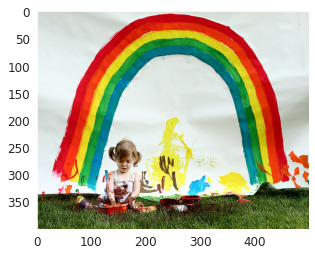

In [24]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq
--------------------Predicted--------------------
startseq woman in striped shirt is riding bicycle on rock climbing endseq


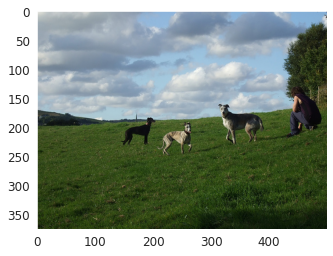

In [48]:
generate_caption("1032122270_ea6f0beedb.jpg")

---------------------Actual---------------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq
--------------------Predicted--------------------
startseq boy is jumping in the water tucked tucked along sidewalk endseq


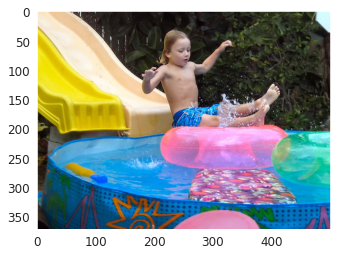

In [49]:

generate_caption("1077546505_a4f6c4daa9.jpg")